# Introduction to Quantum Information and Quantum Machine Learning

## Project 2

Mateusz Tabaszewski 151945

## Imports

In [21]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit_aer import Aer
from qiskit.compiler import transpile
from qiskit.visualization import *
from numpy import pi
from qiskit.visualization import plot_histogram
from qiskit.transpiler import generate_preset_pass_manager
from statistics import stdev
import numpy as np
import pandas as pd

## Variables

In [22]:
backend = Aer.get_backend('statevector_simulator')
nx=2
shots=2048
num_tests = 5

## Functions

In [23]:
def run_simple_circuit(nx, shots, backend, gate_list, measurement=None):
    if measurement is not None:
        if measurement == "XX":
            gate_list += [
                    ("barrier", (0, 1)),
                    ("h", 0),
                    ("h", 1),
                    ("measure", (0, 0)),
                    ("measure", (1, 1))
            ]
        elif measurement == "YY":
            gate_list += [
                    ("barrier", (0, 1)),
                    ("sdg", 0),
                    ("sdg", 1),
                    ("h", 0),
                    ("h", 1),
                    ("measure", (0, 0)),
                    ("measure", (1, 1))
            ]
        elif measurement == "XZ":
            gate_list += [
                    ("barrier", (0, 1)),
                    ("measure", (0, 0)),
                    ("h", 1),
                    ("measure", (1, 1))
            ]
        else:
            raise ValueError("Invalid Measurement Type")
        
    qx = QuantumRegister(nx)
    cx = ClassicalRegister(nx)
    circuit = QuantumCircuit(qx, cx)

    for gate, qubits in gate_list:
        if gate == "x":
            circuit.x(qx[qubits])
        elif gate == "h":
            circuit.h(qx[qubits])
        elif gate == "sdg":
            circuit.sdg(qx[qubits])
        elif gate == "cx":
            control, target = qubits
            circuit.cx(qx[control], qx[target])
        elif gate == "s":
            circuit.s(qx[qubits])
        elif gate == "tdg":
            circuit.tdg(qx[qubits])
        elif gate == "t":
            circuit.t(qx[qubits])
        elif gate == "barrier":
            if isinstance(qubits, tuple):
                circuit.barrier(qx[qubits[0]], qx[qubits[1]])
            else:
                circuit.barrier(qx[qubits])
        elif gate == "measure":
            q, c = qubits
            circuit.measure(qx[q], cx[c])

    results = []
    for i in range(3):
        job_result = backend.run(transpile(circuit, backend), shots=shots).result()
        results.append(job_result)

    job_result = results[-1]
    counts = job_result.get_counts(circuit)
    return circuit, results, counts


In [24]:
def transform_counts_relative(counts_list):
    for counts in counts_list:
        sum_counts = 0
        for key in counts:
            sum_counts += counts[key]
        for key in counts:
            counts[key] /= sum_counts
    return counts_list

In [25]:
def calculate_sum_std(all_means, all_stds):
    return np.sum(np.array(all_means)), np.sqrt(np.sum(np.array(all_stds)**2))

In [26]:
def get_table(all_counts, opt_name1="Pw(X)", opt_name2="Px(Y)", round_val=5):
    aggregated_data = {}
    mean_table = {}
    std_table = {}
    final_table = {}
    for count_list in all_counts:
        for key in count_list:
            if key not in aggregated_data:
                aggregated_data[key] = []
            aggregated_data[key].append(count_list[key])
    for key in aggregated_data:
        mean_table[key] = sum(aggregated_data[key])/len(aggregated_data[key])
        std_table[key] = stdev(aggregated_data[key])
    
    final_table["Case Number - yx"] = ["00", "10", "01", "11"]
    final_table[f"{opt_name1} - q0"] = []
    final_table[f"{opt_name2} - q1"] = []
    final_table[f"{opt_name1} * {opt_name2}"] = []
    final_table[f"p(yx)"] = []
    final_table[f"{opt_name1} * {opt_name2} * p(yx)"] = []
    final_table[f"<{opt_name1} | {opt_name2}>"] = []

    all_means = []
    all_stds = []

    for val in final_table["Case Number - yx"]:
        if val[0] == "1":
            val1 = -1
        else:
            val1 = 1
        if val[1] == "1":
            val2 = -1
        else:
            val2 = 1
        val12 = val1*val2
        pyx_mean = mean_table[val]
        pyx_std = std_table[val]
        pyx_str = f"{round(pyx_mean, round_val)} +/- {round(pyx_std, round_val)}"
        val12_pyx_mean = val12 * pyx_mean
        val12_pyx_std = val12 * pyx_std
        val12_pyx_str = f"{round(val12_pyx_mean, round_val)} +/- {round(val12_pyx_std, round_val)}"

        final_table[f"{opt_name1} - q0"].append(val1)
        final_table[f"{opt_name2} - q1"].append(val2)
        final_table[f"{opt_name1} * {opt_name2}"].append(val12)
        final_table[f"p(yx)"].append(pyx_str)
        final_table[f"{opt_name1} * {opt_name2} * p(yx)"].append(val12_pyx_str)

        all_means.append(val12_pyx_mean)
        all_stds.append(val12_pyx_std)

    total_sum, total_std = calculate_sum_std(all_means, all_stds)
    final_table[f"<{opt_name1} | {opt_name2}>"].append(f"{round(total_sum, round_val)} +/- {round(total_std, round_val)}")

    for i in range(len(final_table["Case Number - yx"])-1):
        final_table[f"<{opt_name1} | {opt_name2}>"].append(np.nan)
        
    return pd.DataFrame(final_table), total_sum, total_std

## X x W

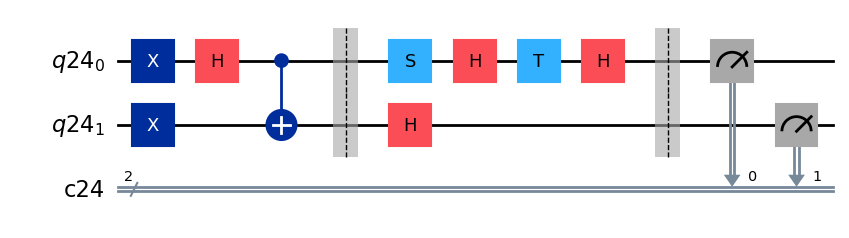

In [27]:
gates = [
    ("x", 0),
    ("x", 1),
    ("h", 0),
    ("cx", (0, 1)),
    ("barrier", (0, 1)),
    ("s", (0)),
    ("h", (0)),
    ("t", (0)),
    ("h", (0)),
    ("h", (1)),
    ("barrier", (0, 1)),
    ("measure", (0, 0)),
    ("measure", (1, 1))
]

all_counts = []
all_results = []
for i in range(num_tests):
    circuit, results, counts = run_simple_circuit(
        nx=nx,
        shots=shots,
        backend=backend,
        gate_list=gates
    )
    all_counts.append(counts)
    all_results.append(results)

circuit.draw(output="mpl")

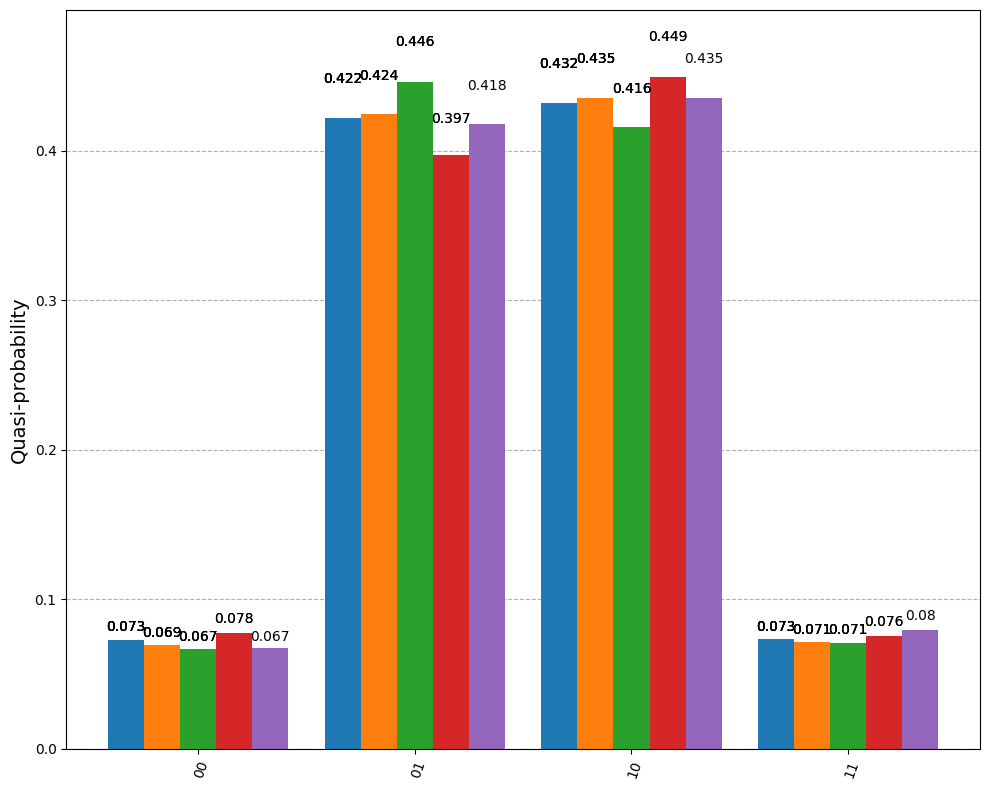

In [28]:
plot_histogram(transform_counts_relative(all_counts), figsize=(10, 8))

In [29]:
final_table, total_sum_xw, total_std_xw = get_table(all_counts, opt_name1="Pw(X)", opt_name2="Px(Y)")
final_table

,Case Number - yx,Pw(X) - q0,Px(Y) - q1,Pw(X) * Px(Y),p(yx),Pw(X) * Px(Y) * p(yx),<Pw(X) | Px(Y)>
0,00,1,1,1,0.0708 +/- 0.00446,0.0708 +/- 0.00446,-0.71016 +/- 0.02182
1,10,-1,1,-1,0.4335 +/- 0.01183,-0.4335 +/- -0.01183,NaN
2,01,1,-1,-1,0.42158 +/- 0.01741,-0.42158 +/- -0.01741,NaN
3,11,-1,-1,1,0.07412 +/- 0.00361,0.07412 +/- 0.00361,NaN


## X x V

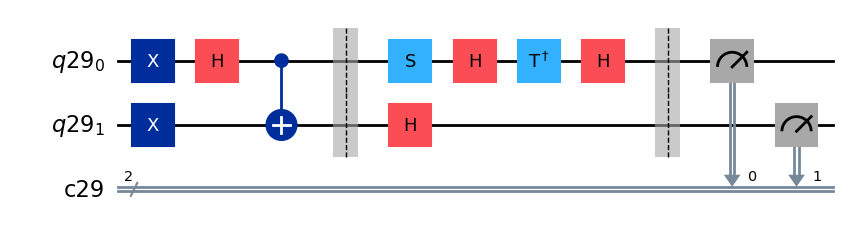

In [30]:
gates = [
    ("x", 0),
    ("x", 1),
    ("h", 0),
    ("cx", (0, 1)),
    ("barrier", (0, 1)),
    ("s", (0)),
    ("h", (0)),
    ("tdg", (0)),
    ("h", (0)),
    ("h", (1)),
    ("barrier", (0, 1)),
    ("measure", (0, 0)),
    ("measure", (1, 1))
]


all_counts = []
all_results = []
for i in range(num_tests):
    circuit, results, counts = run_simple_circuit(
        nx=nx,
        shots=shots,
        backend=backend,
        gate_list=gates
    )
    all_counts.append(counts)
    all_results.append(results)

circuit.draw(output="mpl")

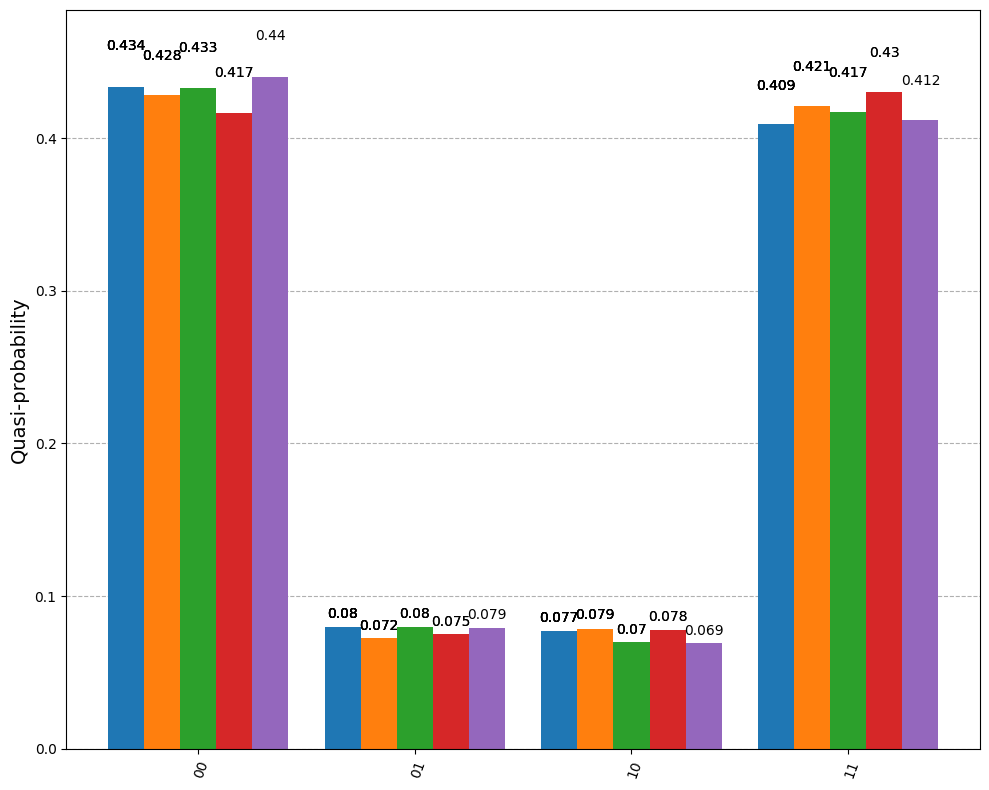

In [31]:
plot_histogram(transform_counts_relative(all_counts), figsize=(10, 8))

In [32]:
final_table, total_sum_xv, total_std_xv = get_table(all_counts, opt_name1="Pv(X)", opt_name2="Px(Y)")
final_table

,Case Number - yx,Pv(X) - q0,Px(Y) - q1,Pv(X) * Px(Y),p(yx),Pv(X) * Px(Y) * p(yx),<Pv(X) | Px(Y)>
0,00,1,1,1,0.43027 +/- 0.00875,0.43027 +/- 0.00875,0.69609 +/- 0.01338
1,10,-1,1,-1,0.07461 +/- 0.00462,-0.07461 +/- -0.00462,NaN
2,01,1,-1,-1,0.07734 +/- 0.00348,-0.07734 +/- -0.00348,NaN
3,11,-1,-1,1,0.41777 +/- 0.00831,0.41777 +/- 0.00831,NaN


## Z x W

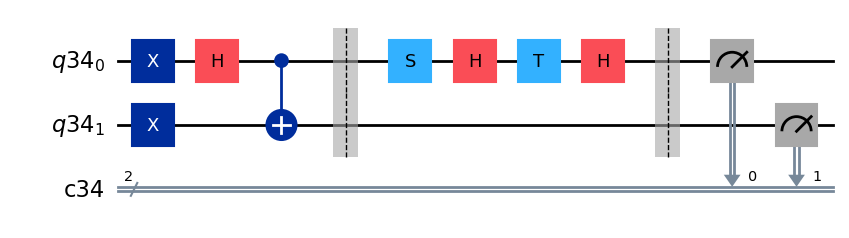

In [33]:
gates = [
    ("x", 0),
    ("x", 1),
    ("h", 0),
    ("cx", (0, 1)),
    ("barrier", (0, 1)),
    ("s", (0)),
    ("h", (0)),
    ("t", (0)),
    ("h", (0)),
    ("barrier", (0, 1)),
    ("measure", (0, 0)),
    ("measure", (1, 1))
]

all_counts = []
all_results = []
for i in range(num_tests):
    circuit, results, counts = run_simple_circuit(
        nx=nx,
        shots=shots,
        backend=backend,
        gate_list=gates
    )
    all_counts.append(counts)
    all_results.append(results)

circuit.draw(output="mpl")

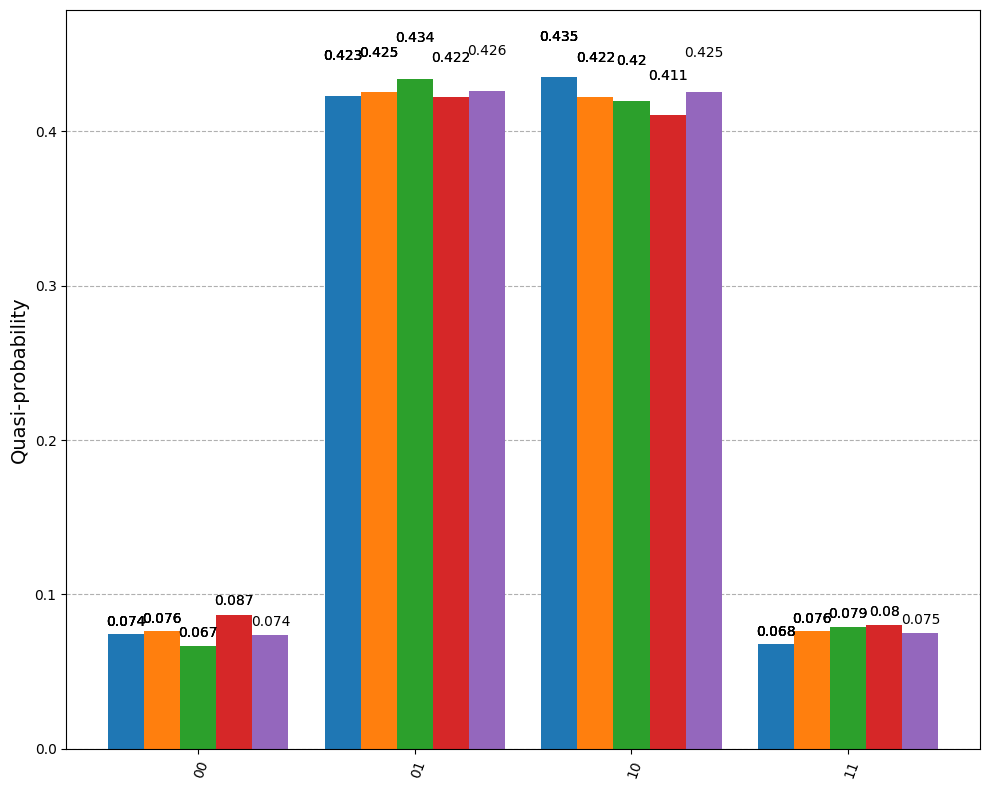

In [34]:
plot_histogram(transform_counts_relative(all_counts), figsize=(10, 8))

In [35]:
final_table, total_sum_zw, total_std_zw = get_table(all_counts, opt_name1="Pw(X)", opt_name2="Pz(Y)")
final_table

,Case Number - yx,Pw(X) - q0,Pz(Y) - q1,Pw(X) * Pz(Y),p(yx),Pw(X) * Pz(Y) * p(yx),<Pw(X) | Pz(Y)>
0,00,1,1,1,0.07559 +/- 0.00724,0.07559 +/- 0.00724,-0.69746 +/- 0.01326
1,10,-1,1,-1,0.42266 +/- 0.00884,-0.42266 +/- -0.00884,NaN
2,01,1,-1,-1,0.42607 +/- 0.00472,-0.42607 +/- -0.00472,NaN
3,11,-1,-1,1,0.07568 +/- 0.00481,0.07568 +/- 0.00481,NaN


## Z x V

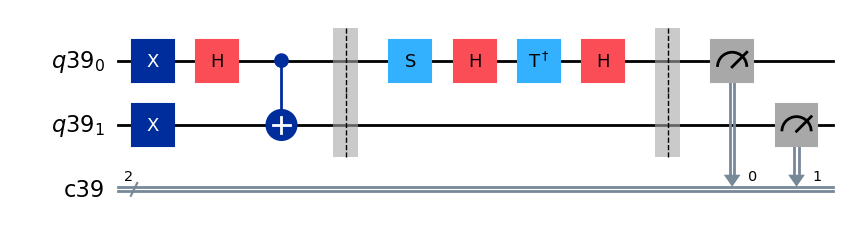

In [36]:
gates = [
    ("x", 0),
    ("x", 1),
    ("h", 0),
    ("cx", (0, 1)),
    ("barrier", (0, 1)),
    ("s", (0)),
    ("h", (0)),
    ("tdg", (0)),
    ("h", (0)),
    ("barrier", (0, 1)),
    ("measure", (0, 0)),
    ("measure", (1, 1))
]

all_counts = []
all_results = []
for i in range(num_tests):
    circuit, results, counts = run_simple_circuit(
        nx=nx,
        shots=shots,
        backend=backend,
        gate_list=gates
    )
    all_counts.append(counts)
    all_results.append(results)

circuit.draw(output="mpl")

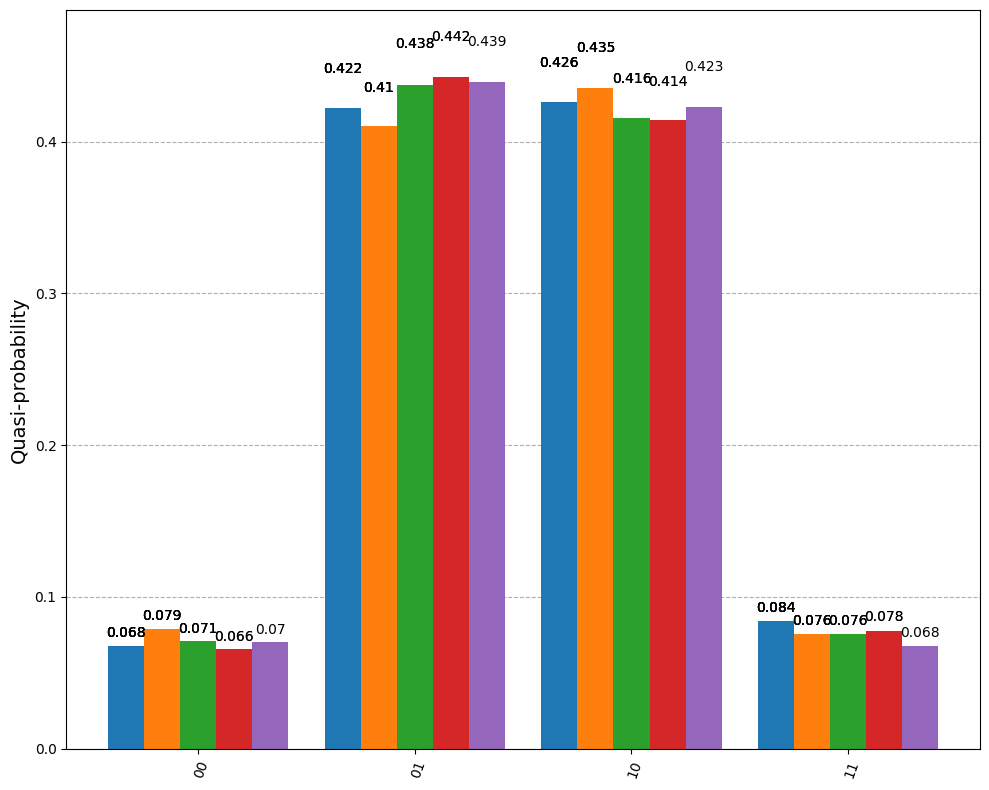

In [37]:
plot_histogram(transform_counts_relative(all_counts), figsize=(10, 8))

In [38]:
final_table, total_sum_zv, total_std_zv = get_table(all_counts, opt_name1="Pv(X)", opt_name2="Pz(Y)")
final_table

,Case Number - yx,Pv(X) - q0,Pz(Y) - q1,Pv(X) * Pz(Y),p(yx),Pv(X) * Pz(Y) * p(yx),<Pv(X) | Pz(Y)>
0,00,1,1,1,0.0709 +/- 0.00504,0.0709 +/- 0.00504,-0.70586 +/- 0.01778
1,10,-1,1,-1,0.42266 +/- 0.00849,-0.42266 +/- -0.00849,NaN
2,01,1,-1,-1,0.43027 +/- 0.01362,-0.43027 +/- -0.01362,NaN
3,11,-1,-1,1,0.07617 +/- 0.00576,0.07617 +/- 0.00576,NaN


In [39]:
all_means = [total_sum_xw, -total_sum_xv, total_sum_zw, total_sum_zv]
all_stds = [total_std_xw, total_std_xv, total_std_zw, total_std_zv]

solution_sum, solution_std = calculate_sum_std(all_means, all_stds)
expected_value = -2*np.sqrt(2)

print(f"Expected Value: {expected_value}")
print(f"Final Value: {solution_sum} +/- {solution_std}")

Expected Value: -2.8284271247461903
Final Value: -2.8095703125 +/- 0.033868561643114366
